In [1]:
 # Copyright 2023 Akvelon Inc.
 #
 # Licensed to the Apache Software Foundation (ASF) under one
 # or more contributor license agreements.  See the NOTICE file
 # distributed with this work for additional information
 # regarding copyright ownership.  The ASF licenses this file
 # to you under the Apache License, Version 2.0 (the
 # "License"); you may not use this file except in compliance
 # with the License.  You may obtain a copy of the License at
 #
 #     http://www.apache.org/licenses/LICENSE-2.0
 #
 # Unless required by applicable law or agreed to in writing, software
 # distributed under the License is distributed on an "AS IS" BASIS,
 # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
 # See the License for the specific language governing permissions and
 # limitations under the License.

In [2]:
import pandas as pd
import torch

import category_encoders as ce
from sklearn.model_selection import train_test_split
from autoembedder import Autoembedder, dataloader, fit

In [3]:
input_data = pd.read_csv('../data/dtc_opportunity.csv')

torch.set_default_dtype(torch.float64)
cat_columns = [x for x in list(set(input_data.columns) - {'Amount'})]
ce_hash = ce.HashingEncoder(cols=cat_columns, n_components=64)

Encode the data with hasher

In [4]:
hashed_input_data = ce_hash.fit_transform(input_data)
hashed_input_data['Amount'] = hashed_input_data['Amount'].astype(float)
hashed_input_data['Amount'] = (hashed_input_data['Amount'] - hashed_input_data['Amount'].mean())/hashed_input_data['Amount'].std()

for col in set(hashed_input_data.columns) - {'Amount'}:
    hashed_input_data[col] = hashed_input_data[col].astype('category')

In [5]:
train_df, valid_df = train_test_split(hashed_input_data,
                                   random_state=42,
                                   test_size=0.1,
                                   shuffle=True)

Define torch autoencoder model parameters

In [6]:
parameters = {
    # "cat_columns": list(set(hashed_input_data.columns) - {'Amount'}),
    "hidden_layers": [[25, 20], [20, 10]],
    "epochs": 10,
    "lr": 0.0001,
    "verbose": 1,
    "batch_size": 4,
}

Define dataloaders for training

In [7]:
train_dl = dataloader(train_df, parameters)
valid_dl = dataloader(valid_df, parameters)

Train the model

Num_cont_features is the number of columns with continuous values

In [8]:
list_cat = [(64, 32)]

model = Autoembedder(parameters, num_cont_features=1, embedding_sizes=list_cat)

fit(parameters, model, train_dl, valid_dl)

Set model config: {'hidden_layers': [[25, 20], [20, 10]], 'epochs': 10, 'lr': 0.0001, 'verbose': 1, 'batch_size': 4}
Model `in_features`: 33


[1/150]   1%|           [00:00<?]

Epoch [1/10]: validation loss: 0.7720246


[1/150]   1%|           [00:00<?]

Epoch [2/10]: validation loss: 0.4851550


[1/150]   1%|           [00:00<?]

Epoch [3/10]: validation loss: 0.2808689


[1/150]   1%|           [00:00<?]

Epoch [4/10]: validation loss: 0.1683305


[1/150]   1%|           [00:00<?]

Epoch [5/10]: validation loss: 0.1039945


[1/150]   1%|           [00:00<?]

Epoch [6/10]: validation loss: 0.0662733


[1/150]   1%|           [00:00<?]

Epoch [7/10]: validation loss: 0.0448227


[1/150]   1%|           [00:00<?]

Epoch [8/10]: validation loss: 0.0331243


[1/150]   1%|           [00:00<?]

Epoch [9/10]: validation loss: 0.0268945


[1/150]   1%|           [00:00<?]

Epoch [10/10]: validation loss: 0.0235804


Autoembedder(
  (embeddings): ModuleList(
    (0): Embedding(64, 32)
  )
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=33, bias=True)
  )
)

Save the torch model

In [9]:
torch.save(model.state_dict(), 'pretrained/encoder.pth')

In [10]:
model.eval()

Autoembedder(
  (embeddings): ModuleList(
    (0): Embedding(64, 32)
  )
  (encoder): Sequential(
    (0): Linear(in_features=33, out_features=25, bias=True)
    (1): Linear(in_features=25, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=33, bias=True)
  )
)

In [11]:
test_df = pd.read_csv('../data/dtc_opportunity_test.csv')

Fit anomaly detector, pack into dict and then save for later use

In [12]:
import hdbscan

from joblib import dump

# passing our data through autoencoder and then train clusterer on latents

training_df_encoded = pd.DataFrame()
model(x_cont=torch.Tensor(train_df['Amount'].values).view(1, -1), x_cat=torch.Tensor(train_df.drop('Amount', axis=1).values).T)
result_dataframe = training_df_encoded.append(pd.DataFrame(model.code_value.detach().numpy()))

# adding model specific parameters to serialized file
# in our case we only have 1 feature that represented by number: amount
clusterer = hdbscan.HDBSCAN(prediction_data=True).fit(result_dataframe)
additional_parameters = {'params': parameters, 'list_cat': list_cat, 'num_cont_features': 1}

dump(clusterer, './pretrained/anomaly_detection.model')
dump(additional_parameters, './pretrained/model.params')

C:\Users\Marko\AppData\Local\Temp\ipykernel_23700\2722834472.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_dataframe = training_df_encoded.append(pd.DataFrame(model.code_value.detach().numpy()))


['./pretrained/model.params']

<AxesSubplot: ylabel='$\\lambda$ value'>

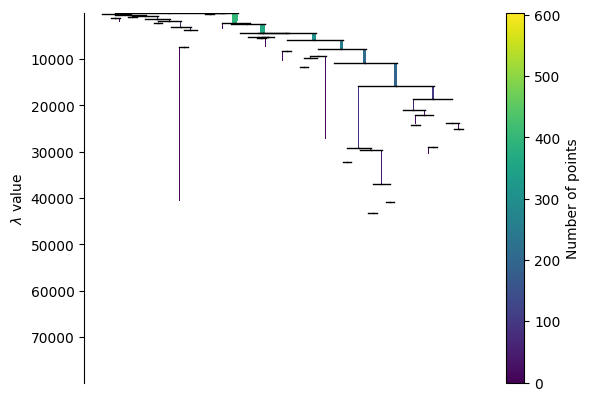

In [13]:
clusterer.condensed_tree_.plot()